In [1]:
import sys
import glob
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### Load the network and the best weights

In [2]:
networks_path = '../trained_networks/'
# depth level = 1, loss function: MAPE
# optim_run = '20201206-221201'
# depth level = 1, loss function: MAE
optim_run = '20201206-221238'
# depth level = 2, loss function: MAPE
# optim_run = '20201207-154625'
# depth level = 2, loss function: MAE
# optim_run = '20201207-154851'
checkpoint_path = networks_path + optim_run + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(networks_path + optim_run + '/parameters.pkl', 'rb'))
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
best_model = tf.keras.models.load_model(best_checkpoint, compile=True)
print('Loaded network from {}.'.format(best_checkpoint))

Loaded network from ../trained_networks/20201206-221238/checkpoints/weights.1610-0.40.h5.


#### We need mean and standard deviation of the training set to normalize the data

In [3]:
try:
    x_train_mean = network_parameters['x_train_mean']
    x_train_std  = network_parameters['x_train_std']
except:
    # Load the data used to train the network to compute the mean
    # and standard deviation of the training set if this is not
    # contained in the parameters file
    data_folder = '../pan/npz_files'
    inertia = {'training': np.arange(2,11)}
    _, x, y = load_data(data_folder, inertia)
    x['train'] = x.pop('training')
    y['train'] = y.pop('training')
    x_train_mean = np.mean(x['train'])
    x_train_std = np.std(x['train'])

In [4]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 596, 16)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 16)           0         
_________________________________________________________________
re_lu (ReLU)                 (None, 149, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 145, 32)           2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 32)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 36, 32)            0

#### Load the new data

In [5]:
data_file = '../pan/ieee14_H={:.1f}.npz'
data = [np.load(data_file.format(h), allow_pickle=True) for h in [3.5,8.5]]

time = [data[0]['time']]
for i in range(1,len(data)):
    time.append(data[i]['time'] + data[i-1]['time'][-1])
time = np.concatenate(time)
# time = data['time']
N_samples = time.size
omega_coi = (np.concatenate([entry['omega_coi'] for entry in data]) - x_train_mean) / x_train_std

simulation_parameters = data[0]['parameters'].item()
dt = 1 / simulation_parameters['frand']
window_dur = 60 # [s]
window_size = int(window_dur / dt)
window_step = 10
print('Window size: {:d} samples'.format(window_size))

omega_coi_sliding, indexes = slide_window(omega_coi, window_size, window_step=window_step)
print('Number of trials: {:d}'.format(omega_coi_sliding.shape[0]))

Window size: 600 samples
Number of trials: 7140


In [6]:
x = tf.constant(omega_coi_sliding, dtype=tf.float32)
y = np.squeeze(best_model.predict(x))
H = pd.DataFrame(data = {'inertia': y}).rolling(50).mean().to_numpy()
time = np.arange(H.size) * window_step * dt

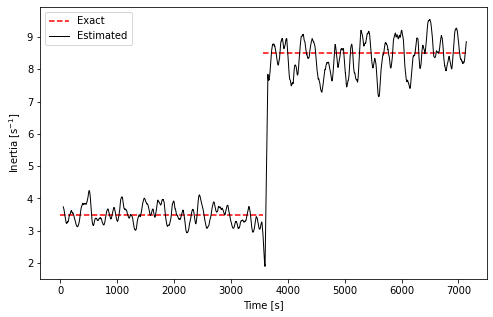

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(time[[0,int(time.size/2)]], simulation_parameters['H'] + np.zeros(2), 'r--', label='Exact')
ax.plot(time[[int(time.size/2),-1]], simulation_parameters['H'] + 5 + np.zeros(2), 'r--')
ax.plot(time, H, 'k', lw=1, label='Estimated')
# ax.set_ylim([0,10])
ax.legend(loc='best')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Inertia [$\mathrm{s}^{-1}$]');